In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip install apache-log-parser 
import apache_log_parser
%matplotlib inline

## Load and parse the data
本案例参考 Nikolay Koldunov（koldunovn@gmail.com）文章完成

我们使用[apache-log-parser](https://github.com/rory/apache-log-parser)进行apalce log分析。log解析前我们需要了解对应的网站的Apahce log的配置。 这里我们已经知道待分析网站的log格式为:  
    
    format = r'%V %h  %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\" %T'
    
对应的各字段代表内容如下：(参考[stackoverflow](http://stackoverflow.com/questions/9234699/understanding-apache-access-log)):
        
    %V  - 根据 UseCanonicalName 设置的服务器名字
    %h  - 远程主机（客户端 IP）
    %l  - identity of the user determined by identd (not usually used since not reliable)
    %u  - 由 HTTP authentication 决定的 user name
    %t  - 服务器完成处理这个请求的时间
    %r  - 来自客户端的请求行。 （"GET / HTTP/1.0"）
    %>s - 服务器端返回给客户端的状态码（200， 404 等等。）
    %b  - 响应给客户端的响应报文大小 （in bytes）
    \"%{Referer}i\"  - Referer is the page that linked to this URL.
    \"%{User-Agent}i\"  - the browser identification string
    %T  - Apache 请求时间

In [2]:
# 这个地方是要使用的log的日志的格式
fformat = '%V %h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\" %T'

创建解析器

In [3]:
p = apache_log_parser.make_parser(fformat)

比如：
        
        koldunov.net 85.26.235.202 - - [16/Mar/2013:00:19:43 +0400] "GET /?p=364 HTTP/1.0" 200 65237 "http://koldunov.net/?p=364" "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11" 0

In [4]:
sample_string = 'koldunov.net 85.26.235.202 - - [16/Mar/2013:00:19:43 +0400] "GET /?p=364 HTTP/1.0" 200 65237 "http://koldunov.net/?p=364" "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11" 0'

In [5]:
data = p(sample_string)

In [6]:
data

{'remote_host': '85.26.235.202',
 'remote_logname': '-',
 'remote_user': '-',
 'request_first_line': 'GET /?p=364 HTTP/1.0',
 'request_header_referer': 'http://koldunov.net/?p=364',
 'request_header_user_agent': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
 'request_header_user_agent__browser__family': 'Chrome',
 'request_header_user_agent__browser__version_string': '23.0.1271',
 'request_header_user_agent__is_mobile': False,
 'request_header_user_agent__os__family': 'Windows XP',
 'request_header_user_agent__os__version_string': '',
 'request_http_ver': '1.0',
 'request_method': 'GET',
 'request_url': '/?p=364',
 'request_url_fragment': '',
 'request_url_hostname': None,
 'request_url_netloc': '',
 'request_url_password': None,
 'request_url_path': '/',
 'request_url_port': None,
 'request_url_query': 'p=364',
 'request_url_query_dict': {'p': ['364']},
 'request_url_query_list': [('p', '364')],
 'request_url_query_simple_dict

In [7]:
log = open('./data/apache_access_log').readlines()

### 解析每一行，并创建dict list

In [8]:
import sys

log_list = []
for line in log:
    try:
        data = p(line)
    except:
        sys.stderr.write('Unable to parse %s' % line)
    data['time_received'] = data['time_received'][1:12] + ' ' + data['time_received'][13:21] + ' ' + data['time_received'][22:27]
    
    log_list.append(data)

## 准备网站日志数据

把字典转化为DataFrame

In [9]:
df = pd.DataFrame(log_list)

In [10]:
df.columns

Index(['remote_host', 'remote_logname', 'remote_user', 'request_first_line',
       'request_header_referer', 'request_header_user_agent',
       'request_header_user_agent__browser__family',
       'request_header_user_agent__browser__version_string',
       'request_header_user_agent__is_mobile',
       'request_header_user_agent__os__family',
       'request_header_user_agent__os__version_string', 'request_http_ver',
       'request_method', 'request_url', 'request_url_fragment',
       'request_url_hostname', 'request_url_netloc', 'request_url_password',
       'request_url_path', 'request_url_port', 'request_url_query',
       'request_url_query_dict', 'request_url_query_list',
       'request_url_query_simple_dict', 'request_url_scheme',
       'request_url_username', 'response_bytes_clf', 'server_name2', 'status',
       'time_received', 'time_received_datetimeobj', 'time_received_isoformat',
       'time_received_tz_datetimeobj', 'time_received_tz_isoformat',
       'time_recei

In [11]:
df = df[['status', 'response_bytes_clf', 'remote_host', 'request_first_line', 'time_received']]

In [12]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line,time_received
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25 +0400
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25 +0400
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25 +0400
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25 +0400
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25 +0400


把time_received变成index，这里使用了pop，把对应的列弹出并进行返回。

In [13]:
df.index = pd.to_datetime(df.pop('time_received'))

In [14]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


In [15]:
df.info()      # status不是int

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6634 entries, 2013-03-16 04:00:25 to 2013-03-16 20:19:30
Data columns (total 4 columns):
status                6634 non-null object
response_bytes_clf    6634 non-null object
remote_host           6634 non-null object
request_first_line    6634 non-null object
dtypes: object(4)
memory usage: 259.1+ KB


> 转化实际上有很多种方法，我们这里使用 **`loc`** 进行搜索，然后进行转换。

In [16]:
df.loc[:, 'status'] = df['status'].astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6634 entries, 2013-03-16 04:00:25 to 2013-03-16 20:19:30
Data columns (total 4 columns):
status                6634 non-null int64
response_bytes_clf    6634 non-null object
remote_host           6634 non-null object
request_first_line    6634 non-null object
dtypes: int64(1), object(3)
memory usage: 259.1+ KB


> ### 而response_bytes_clf列有些数据包含字符串'-'，我们无法直接使用 **`astype`** :

In [18]:
df['response_bytes_clf'][93]

'-'

### 将'-'转换成NaN，同时单位转换为M。

In [19]:
def dash2nan(x):
    if x =='-':
        x = np.nan
    else:
        x = float(x) / 1048576
    
    return x

In [20]:
df['response_bytes_clf'] = df['response_bytes_clf'].apply(dash2nan)

In [21]:
df.head(20)

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0
2013-03-16 04:00:25,200,0.033319,109.165.31.156,GET /modules/ja_transmenu/transmenu.js HTTP/1.0
2013-03-16 04:00:25,200,0.039610,109.165.31.156,GET /templates/ja_procyon/images/header-logo.j...
2013-03-16 04:00:25,200,0.001791,109.165.31.156,GET /favicon.ico HTTP/1.0
2013-03-16 04:00:26,200,0.000052,109.165.31.156,GET /templates/ja_procyon/images/arrow-on.gif ...


### 流量分析

根据时间看网站下载流量

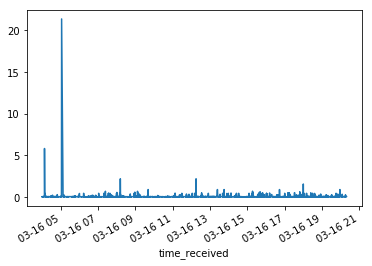

In [22]:
df['response_bytes_clf'].plot()

按照5分钟进行重新采样，统计访问次数（实际上也就是 **`聚集操作`** ）
> 是通过 **`resample`** 方法进行的。

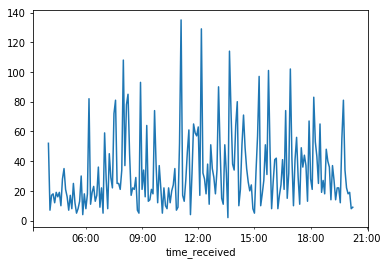

In [23]:
df_s = df['response_bytes_clf'].resample('5t').count()
df_s.plot()     # 这个地方的绘图是计数而不是下载的流量。

In [24]:
df_s

time_received
2013-03-16 04:00:00    52
2013-03-16 04:05:00     7
2013-03-16 04:10:00    17
2013-03-16 04:15:00    18
2013-03-16 04:20:00    12
2013-03-16 04:25:00    19
2013-03-16 04:30:00    16
2013-03-16 04:35:00    19
2013-03-16 04:40:00    10
2013-03-16 04:45:00    28
2013-03-16 04:50:00    35
2013-03-16 04:55:00    21
2013-03-16 05:00:00    16
2013-03-16 05:05:00     7
2013-03-16 05:10:00    17
2013-03-16 05:15:00     8
2013-03-16 05:20:00    25
2013-03-16 05:25:00    12
2013-03-16 05:30:00     5
2013-03-16 05:35:00     8
2013-03-16 05:40:00    13
2013-03-16 05:45:00    30
2013-03-16 05:50:00     4
2013-03-16 05:55:00    18
2013-03-16 06:00:00     8
2013-03-16 06:05:00    18
2013-03-16 06:10:00    82
2013-03-16 06:15:00    11
2013-03-16 06:20:00    19
2013-03-16 06:25:00    23
                       ..
2013-03-16 17:50:00    13
2013-03-16 17:55:00    67
2013-03-16 18:00:00    28
2013-03-16 18:05:00    21
2013-03-16 18:10:00    83
2013-03-16 18:15:00    53
2013-03-16 18:20:00    4

### 同时统计访问次数以及流量

> 像下面的 * **`ax1.twinx()`** * 代表创建了第二个Y轴。

                     count       sum
time_received                       
2013-03-16 04:00:00     59  6.957677
2013-03-16 04:10:00     35  0.929472
2013-03-16 04:20:00     31  0.771323
2013-03-16 04:30:00     35  0.771191
2013-03-16 04:40:00     38  0.943575


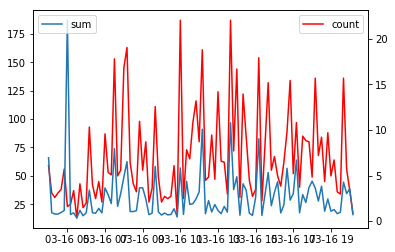

In [25]:
df_b = pd.DataFrame({'count': df['response_bytes_clf'].resample('10t').count(), 
                     'sum': df['response_bytes_clf'].resample('10t').sum()})
print(df_b.head())
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(df_b['count'], color='r', label='count')
ax1.legend(loc=0)
ax2.plot(df_b['sum'], label='sum')
ax2.legend(loc=2)

In [26]:
df_b.head()

,count,sum
time_received,,
2013-03-16 04:00:00,59,6.957677
2013-03-16 04:10:00,35,0.929472
2013-03-16 04:20:00,31,0.771323
2013-03-16 04:30:00,35,0.771191
2013-03-16 04:40:00,38,0.943575


## 流量和访问次数的关系

In [27]:
df_b.corr()      # 也就是相关的关系

,count,sum
count,1.000000,0.512629
sum,0.512629,1.000000


### 考察一下流量高的时间段

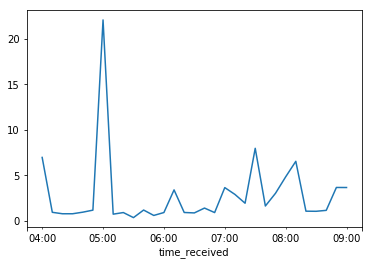

In [28]:
df_b['2013-03-16 2:00':'2013-03-16 9:00']['sum'].plot()

似乎是下载了一本书，一共21M

In [29]:
df[df['response_bytes_clf']>20]

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 05:02:59,200,21.365701,77.50.248.20,GET /books/Bondarenko.pdf HTTP/1.0


通常情况下request大小是多少呢？

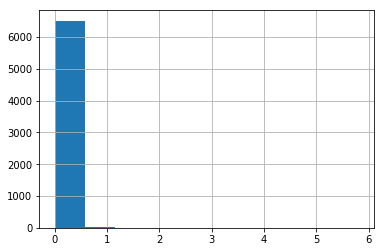

In [30]:
cc = df[df['response_bytes_clf'] < 20]
cc.response_bytes_clf.hist(bins=10)

> 从上面这个图看可以看到大部分的请求都是小于0.5M的，所以我们下面进行更加详细的分析。

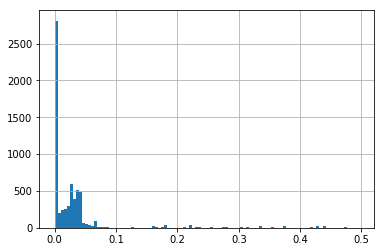

In [31]:
cc = df[df['response_bytes_clf'] < 0.5]
cc.response_bytes_clf.hist(bins=100)

再进一步进行过滤

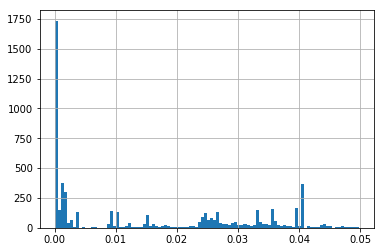

In [32]:
cc = df[(df['response_bytes_clf'] > 0.0) & (df['response_bytes_clf'] < 0.05)]
cc.response_bytes_clf.hist(bins=100)

> 我们可以查看这些小于0.05M的请求到底都是什么请求

In [33]:
cc = df[(df['response_bytes_clf'] > 0.0) & (df['response_bytes_clf'] < 0.05)]
cc.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


## 根据服务器返回状态码进行分析

In [34]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


In [35]:
t_span = '2H'

df_404 = df['status'][df['status'] == 404].resample(t_span).count()
df_403 = df['status'][df['status'] == 403].resample(t_span).count()
df_301 = df['status'][df['status'] == 301].resample(t_span).count()
df_304 = df['status'][df['status'] == 304].resample(t_span).count()
df_200 = df['status'][df['status'] == 200].resample(t_span).count()

status_df = pd.DataFrame({'Not Found': df_404, 
                          'Forbidden': df_403, 
                          'Moved Permanently': df_301, 
                          'Not Modified': df_304,
                         'OK': df_200})

In [36]:
status_df.head()

,Forbidden,Moved Permanently,Not Found,Not Modified,OK
time_received,,,,,
2013-03-16 04:00:00,22,17,3,4.0,375
2013-03-16 06:00:00,26,76,2,2.0,607
2013-03-16 08:00:00,45,83,2,23.0,780
2013-03-16 10:00:00,29,34,4,2.0,699
2013-03-16 12:00:00,27,94,5,3.0,886


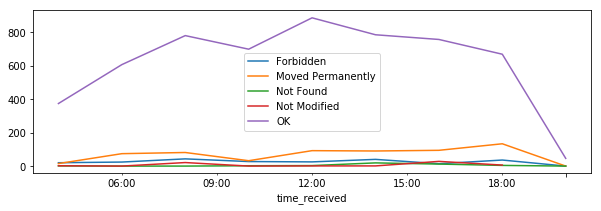

In [37]:
status_df.plot(figsize=(10,3))

> 下面的图是显示错误码的堆叠的比例图，也就是在 **`plot`** 方法里面添加参数 **`stacked`** 为True！！。

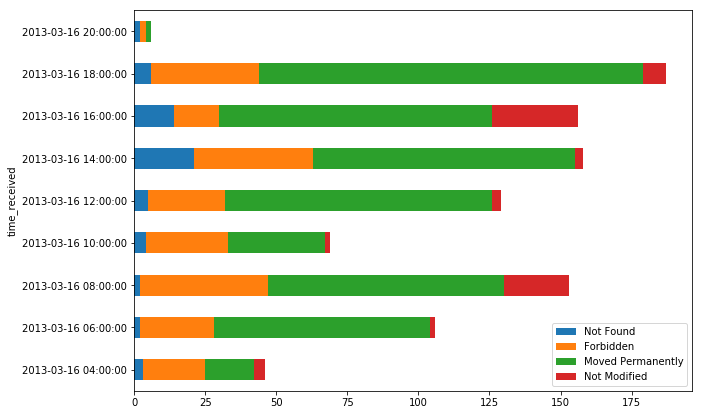

In [38]:
status_df[['Not Found', 'Forbidden', 'Moved Permanently', 'Not Modified']].plot(kind='barh', stacked=True, figsize=(10, 7))

## 根据Status分组

In [39]:
grouped_status = df.groupby('status')

In [40]:
grouped_status.head(2)

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=156.gif HT...
2013-03-16 04:04:23,403,0.001054,5.79.199.116,GET /forum/download/file.php?avatar=216.jpg HT...
2013-03-16 04:04:25,404,0.001063,5.79.199.116,GET /apple-touch-icon-precomposed.png HTTP/1.0
2013-03-16 04:04:26,404,0.001063,5.79.199.116,GET /apple-touch-icon.png HTTP/1.0
2013-03-16 04:13:08,301,0.000232,38.100.21.63,GET /forum HTTP/1.0
2013-03-16 04:13:09,400,0.000999,38.100.21.63,GET /.. HTTP/1.0
2013-03-16 04:13:09,301,0.000234,38.100.21.63,GET /podcast HTTP/1.0


### 统计每组的大小

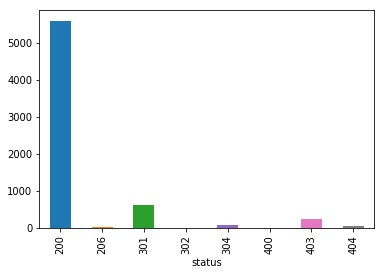

In [41]:
grouped_status.size().plot(kind='bar')

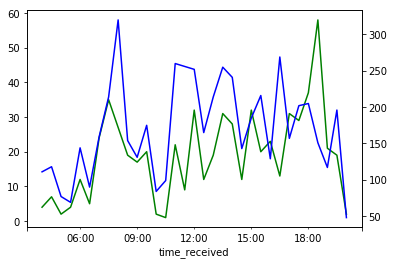

In [42]:
t_span = '30t'
grouped_status.get_group(301)['status'].resample(t_span).count().plot(color='g', label='301')
grouped_status.get_group(200)['status'].resample(t_span).count().plot(color='b', secondary_y=True, label='200')

## IPs

根据IP地址来源统计

In [43]:
df.head()

,status,response_bytes_clf,remote_host,request_first_line
time_received,,,,
2013-03-16 04:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 04:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 04:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 04:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 04:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


In [44]:
ips = df.groupby('remote_host').size()

In [45]:
ips

remote_host
100.44.124.8       26
108.171.252.242    24
109.165.31.156     12
109.171.109.164     4
109.191.82.110     14
109.200.149.88     56
109.205.252.77     32
109.225.55.49      13
109.226.101.186    45
109.230.128.168     9
109.230.128.169    13
109.230.132.244     2
109.87.146.37       4
109.87.148.141     13
111.73.45.49       10
112.101.64.150     35
112.101.64.28      12
112.78.139.130      1
116.25.249.140      1
117.199.193.19      1
117.26.200.81       3
117.27.175.158      1
119.147.6.60        1
120.85.235.128     10
121.205.213.80     16
122.201.18.26       1
123.30.175.30       6
128.69.187.215      2
128.70.195.174      4
128.70.235.42      12
                   ..
95.105.80.236       2
95.106.202.8        1
95.118.89.119      93
95.128.242.177     12
95.137.65.198      35
95.153.169.54      13
95.161.28.2         1
95.190.32.91        2
95.220.98.14        2
95.221.223.190     12
95.25.121.154       1
95.27.28.213        7
95.31.19.80         3
95.32.16.122       1

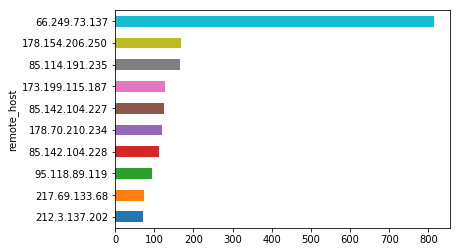

In [46]:
ips_sorted = ips.sort_values()
ips_sorted[-10:].plot(kind='barh')

In [47]:
ips_fd = pd.DataFrame({'Number of requests': ips_sorted[-10:]})
ips_fd = ips_fd.sort_values(by='Number of requests', ascending=False)
ips_fd

,Number of requests
remote_host,
66.249.73.137,814
178.154.206.250,168
85.114.191.235,165
173.199.115.187,127
85.142.104.227,126
178.70.210.234,120
85.142.104.228,111
95.118.89.119,93
217.69.133.68,74


### 按照IP以及Status分组

In [48]:
ips_status = df.groupby(['remote_host', 'status']).size()

In [49]:
ips_status

remote_host      status
100.44.124.8     200        9
                 403        6
                 404       11
108.171.252.242  200       24
109.165.31.156   200       12
109.171.109.164  200        2
                 206        2
109.191.82.110   200       12
                 404        2
109.200.149.88   200       36
                 301       20
109.205.252.77   200       24
                 301        8
109.225.55.49    200       13
109.226.101.186  200       41
                 403        4
109.230.128.168  200        1
                 301        8
109.230.128.169  200       13
109.230.132.244  200        1
                 301        1
109.87.146.37    403        4
109.87.148.141   200       13
111.73.45.49     200       10
112.101.64.150   200       35
112.101.64.28    200       12
112.78.139.130   200        1
116.25.249.140   200        1
117.199.193.19   200        1
117.26.200.81    200        2
                           ..
95.31.19.80      200        3
95.32.16.122    

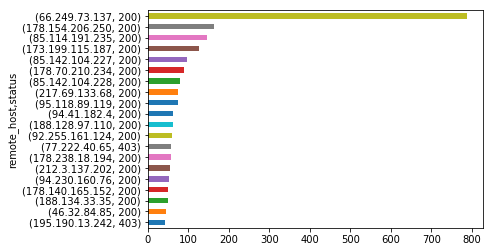

In [50]:
ips_status.sort_values()[-20:].plot(kind='barh')

## 地理信息

利用 **`pygeoip`** 可以根据IP获取对应地理信息，这里我们需要下载对应的文件。

In [51]:
#! pip install pygeoip
import pygeoip
gi = pygeoip.GeoIP('./data/GeoLiteCity.dat', pygeoip.MEMORY_CACHE)

this is how output of the pygeoip looks(we test our top IP from the previous section)：

In [54]:
ipcon = gi.record_by_addr('64.233.161.99')
ipcon

{'area_code': 650,
 'city': 'Mountain View',
 'continent': 'NA',
 'country_code': 'US',
 'country_code3': 'USA',
 'country_name': 'United States',
 'dma_code': 807,
 'latitude': 37.41919999999999,
 'longitude': -122.0574,
 'metro_code': 'San Francisco, CA',
 'postal_code': '94043',
 'region_code': 'CA',
 'time_zone': 'America/Los_Angeles'}

In [59]:
ipcon = []
i = 0
for iip in ips.index:
    rres = gi.record_by_addr(iip)
    if rres ==None:
        print(iip)
        continue
    rres['Number'] = ips[iip]
    # delete some fields we don`t need
    del rres['area_code']
    del rres['dma_code']
    del rres['metro_code']
    del rres['postal_code']
    del rres['region_code']
    del rres['time_zone']
    del rres['country_code']
    
    ipcon.append(rres)
    

> 上面在查找的时候，实际上有一个ip没有查到，所以我们需要把那个删除

In [57]:
# ips['91.224.246.183']
ips.drop('91.224.246.183', inplace=True)

In [58]:
reg = pd.DataFrame(ipcon, index=ips.index)
reg.head()

,Number,city,continent,country_code3,country_name,latitude,longitude
remote_host,,,,,,,
100.44.124.8,26,None,NA,USA,United States,37.7510,-97.8220
108.171.252.242,24,Walnut,NA,USA,United States,34.0115,-117.8535
109.165.31.156,12,Rostov,EU,RUS,Russian Federation,47.2364,39.7139
109.171.109.164,4,Novosibirsk,EU,RUS,Russian Federation,55.0415,82.9346
109.191.82.110,14,Chelyabinsk,EU,RUS,Russian Federation,55.1544,61.4297


### 根据国家进行分组

In [60]:
country = reg.groupby('country_code3')

> 注意，下面在使用 **`agg`** 的时候，给的参数内容是字符串，实际上这个地方我们也可以使用 **`np.sum`** 。

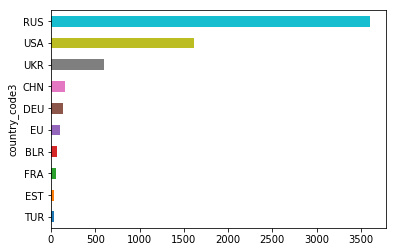

In [62]:
ff = country.Number.agg('sum').copy()
ff.sort_values(inplace=True)
ff[-10:].plot(kind='barh')

通过上面的数据分析，我们可以猜测这个网站是个俄罗斯的网站。

####  按城市进行分组

In [63]:
city = reg.groupby('city')

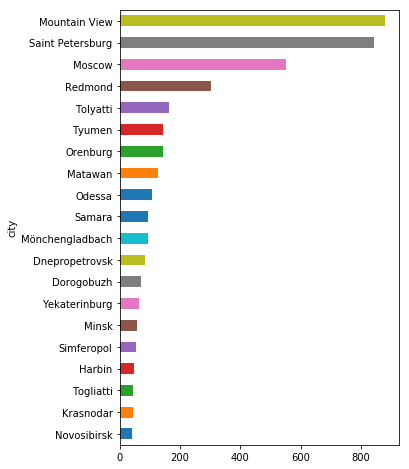

In [65]:
ff = city.Number.agg('sum').copy()
ff.sort_values(inplace=True)
ff[-20:].plot(kind='barh', figsize=(5, 8))

In [66]:
## 还缺少一些根据地图进行绘制的代码